In [1]:
!nvidia-smi

Mon Jun 30 13:20:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-c7h042cw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-c7h042cw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=0fb137d60b736de904e16de05dc7696ff13c8eb92357a642c3d1a750359c9989
  Stored in directory: /tmp/pip-ephem-wheel-cache-qosi1w88/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-06-30 13:21:14--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.33, 3.17

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import argparse
from skimage.measure import regionprops
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- 可视化函数 ---
def show_anns(anns, ax):
    """"""
    if not anns:
        print("警告: 标注列表为空，无可显示内容。")
        return

    sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
    ax.set_autoscale_on(False)
    # 在访问 sorted_anns[0] 之前检查它是否为空
    if sorted_anns:
        h, w = sorted_anns[0]['segmentation'].shape
    else:
        print("警告: 排序后的标注列表为空，无法获取图像维度。")
        return

    transparent_img = np.zeros((h, w, 4), dtype=np.float32)

    for ann in sorted_anns:
        mask = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.75]])
        transparent_img[mask] = color_mask

    ax.imshow(transparent_img, zorder=1)


def compute_centroid(mask):
    """为单个二值掩码计算质心 (x, y)。"""
    props = regionprops(mask.astype(np.uint8))
    # 确保 props 不为空
    return props[0].centroid[::-1] if props else None


def convert_bbox(sam_bbox):
    """将 SAM bbox [x,y,w,h] 转为 [y_min,x_min,y_max,x_max]。"""
    x_min, y_min, w, h = sam_bbox
    return [y_min, x_min, y_min + h, x_min + w]


def compute_bbox_iou(b1, b2):
    """计算 bbox IoU。"""
    y1_min, x1_min, y1_max, x1_max = b1
    y2_min, x2_min, y2_max, x2_max = b2
    ix_min, iy_min = max(x1_min, x2_min), max(y1_min, y2_min)
    ix_max, iy_max = min(x1_max, x2_max), min(y1_max, y2_max)
    iw, ih = max(0, ix_max - ix_min), max(0, iy_max - iy_min)
    inter = iw * ih
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0


def compute_mask_containment(child, parent):
    """子 mask 在父 mask 中覆盖比例 (IoC)。"""
    inter = np.logical_and(child, parent).sum()
    ca = child.sum()
    return inter / ca if ca > 0 else 0


def compute_mask_iou(child, parent):
    """分割掩码 IoU (segment IoU)。"""
    inter = np.logical_and(child, parent).sum()
    union = np.logical_or(child, parent).sum()
    return inter / union if union > 0 else 0


def compute_exact_containment(child, parent):
    """像素级完全包含检查: 子 mask 全部在父 mask 内。"""
    # 确保子掩码是布尔类型再进行索引
    return np.all(parent[child.astype(bool)])


def build_hierarchical_masks(flat_anns,
                             iou_thresh=0.9,
                             ioc_thresh=0.9,
                             seg_iou_thresh=0.5,
                             current_depth=0,
                             max_depth=6):
    """
    递归构建层级掩码，父子判断：
      - bbox IoU >= iou_thresh
      OR - IoC >= ioc_thresh
      OR - mask IoU >= seg_iou_thresh
      OR - 子 mask 像素级完全包含于父 mask
    """
    if not flat_anns:
        return []
    if current_depth >= max_depth:
        # 如果达到最大深度，将当前深度赋给所有剩余的标注
        for a in flat_anns:
            a['depth'] = max_depth
        return sorted(flat_anns, key=lambda x: x['area'], reverse=True)

    for a in flat_anns:
        a['depth'] = current_depth # 分配当前深度
        a.setdefault('parent_id', None) # 初始化 parent_id
        a['substructure'] = [] # 初始化子结构列表
        if 'centroid' not in a or a['centroid'] is None:
            a['centroid'] = compute_centroid(a['segmentation'])

    sorted_anns = sorted(flat_anns, key=lambda x: x['area'], reverse=True)
    used = set() # 跟踪已被分配为子级的掩码
    decomposed = False # 标志，检查此深度是否发生分解

    for i, parent in enumerate(sorted_anns):
        # 如果父级本身已被用作更高级分解的子级，则跳过
        if parent['original_sam_id'] in used:
            continue

        pb, pm = convert_bbox(parent['bbox']), parent['segmentation']
        for j in range(i + 1, len(sorted_anns)):
            child = sorted_anns[j]
            if child['original_sam_id'] in used:
                continue # 如果子级已被分配，则跳过

            cb, cm = convert_bbox(child['bbox']), child['segmentation']
            # 检查父子关系条件
            if (compute_bbox_iou(pb, cb) >= iou_thresh or
                compute_mask_containment(cm, pm) >= ioc_thresh or
                compute_mask_iou(cm, pm) >= seg_iou_thresh or
                compute_exact_containment(cm, pm)):
                child['parent_id'] = parent['original_sam_id']
                # 子级的深度将在递归调用中确定
                parent['substructure'].append(child)
                used.add(child['original_sam_id']) # 标记子级为已使用
                decomposed = True # 指示发生了分解

    # 未被用作子级的掩码（在此深度是顶级，或未找到父级）
    top = [a for a in sorted_anns if a['original_sam_id'] not in used]

    # 如果此层没有发生分解，并且不是初始调用（深度 > 0），
    # 则这些“顶级”掩码是此分支的最终掩码。
    # 此条件有助于终止无法进一步分解的分支。
    if not decomposed and current_depth > 0:
        return top

    # 为下一次子结构递归调用做准备
    next_flat = []
    for t in top:
        if t['substructure']: # 从当前的顶级掩码中收集子结构
            next_flat.extend(t['substructure'])

    # 递归构建收集到的子结构的层次结构
    if next_flat:
        subs = build_hierarchical_masks(next_flat,
                                        iou_thresh, ioc_thresh,
                                        seg_iou_thresh, current_depth + 1,
                                        max_depth)
        # 将递归构建的子结构重新分配给它们的父级
        for t in top:
            t['substructure'] = [c for c in subs if c['parent_id'] == t['original_sam_id']]
        return top # 返回带有完整子结构的顶级掩码
    return top # 如果没有更多子结构，则返回当前的顶级掩码


def collect_info(h_masks):
    """
    递归地收集所有 masks 的信息，包括质心、所有 masks 列表，
    以及每层可分解和不可分解的 mask 数量。
    """
    dec, decomposable_counts, allm = [], {}, []
    non_decomposable_counts = {}

    def dfs(lst):
        for a in lst:
            allm.append(a)

            if a['substructure']:
                if a['centroid']:
                    x, y = a['centroid']
                    d = a['depth']
                    dec.append((x, y, d))
                decomposable_counts[a['depth']] = decomposable_counts.get(a['depth'], 0) + 1
                dfs(a['substructure'])
            else:
                non_decomposable_counts[a['depth']] = non_decomposable_counts.get(a['depth'], 0) + 1

    dfs(h_masks)
    return dec, decomposable_counts, non_decomposable_counts, allm


def main(args, max_depth=6, scale=1, device='cpu'):
    img = cv2.imread(args.image_path)
    if img is None:
        sys.exit(f"读图失败: {args.image_path}")
    h, w = img.shape[:2]
    if scale != 1:
        img = cv2.resize(img, (int(w * scale), int(h * scale)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # init SAM
    sam = sam_model_registry[args.model_type](checkpoint=args.checkpoint)
    sam.to(device=device)
    sam = SamAutomaticMaskGenerator(
        sam,
        pred_iou_thresh=0.86,
        stability_score_thresh=0.92,
        crop_n_layers=2,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100
    )
    anns = sam.generate(img)

    if not anns:
        sys.exit("SAM not working")


    for i, a in enumerate(anns):
        a['original_sam_id'] = i
        a['centroid'] = compute_centroid(a['segmentation'])
        a['depth'] = 0

    # find decomp substructures
    h_masks = build_hierarchical_masks(
        anns,
        iou_thresh=0.9,
        ioc_thresh=0.9,
        seg_iou_thresh=0.5,
        current_depth=0,
        max_depth=max_depth
    )

    # collect info
    dec, decomposable_counts, non_decomposable_counts, allm = collect_info(h_masks)

    all_depths = set(decomposable_counts.keys()).union(non_decomposable_counts.keys())
    mdep = max(all_depths) if all_depths else 0

    decomposable_list = [decomposable_counts.get(i, 0) for i in range(mdep + 1)]
    non_decomposable_list = [non_decomposable_counts.get(i, 0) for i in range(mdep + 1)]

    print("Decomposable substructures per layer:", decomposable_list)
    print("Non-decomposable substructures per layer:", non_decomposable_list)

    # vision
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    ax.axis('off')
    show_anns(allm, ax)

    if dec:
        xs, ys, ds = zip(*dec)
        u = sorted(set(ds))
        cmap = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'magenta'] # 更多颜色以更好区分
        for i, dv in enumerate(u):
            idx = [j for j, d in enumerate(ds) if d == dv]
            ax.scatter(
                np.array(xs)[idx], np.array(ys)[idx],
                color=cmap[i % len(cmap)],
                marker='o', s=80,
                edgecolors='white',alpha=0.9,
                zorder=2,
                label=f'Depth {dv}'
            )
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    return h_masks, dec, allm, decomposable_list, non_decomposable_list

All masks: 230
Decomposable substructures per layer: [30, 17, 10, 1, 0]
Non-decomposable substructures per layer: [24, 66, 66, 15, 1]


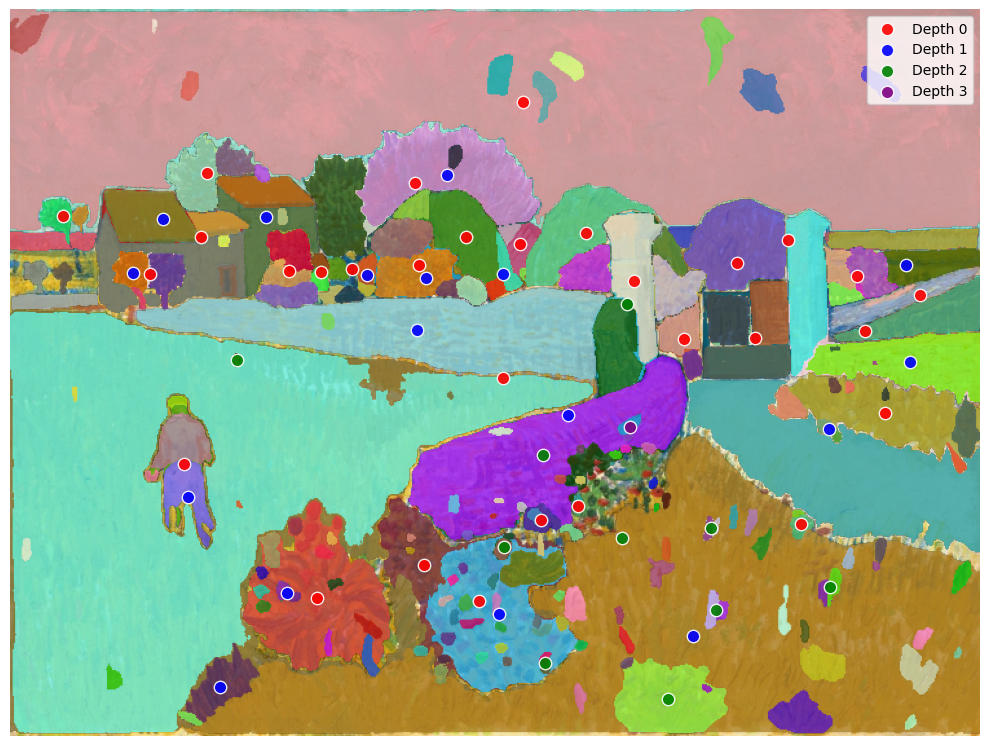

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("--image-path", type=str, required=True, help="input img path")
parser.add_argument("--checkpoint", type=str, required=True, help="SAM checkpoints")
parser.add_argument("--model-type", type=str, default="vit_h", help="SAM model type")
parser.add_argument("--max-recursion-depth", type=int, default=6,help="max level")
parser.add_argument("--img-scale", type=float, default=1.0, help="img scale")
parser.add_argument("--device", type=str, default='cpu', help="device")

class Args:
    image_path = "/content/drive/MyDrive/images/rose2.jpg"
    checkpoint = "sam_vit_h_4b8939.pth"
    model_type = "vit_h"
    max_depth = 6
    scale = 0.75
    device = "cuda" if torch.cuda.is_available() else "cpu"

args = Args()
h_masks, dec, allm, decomp, non_decomp = main(
    args,
    max_depth=args.max_depth,
    scale=args.scale,
    device=args.device
    )

In [ ]:
def img_living(num: list) -> float:
  if num[-1]==0:
    level = len(num)-1
  else:
    level = len(num)
  return float(np.array(num).sum() * level), level

living_value, level = img_living(decomp)
print(f"This img living value is: {living_value}\nlevel: {level}")

This img living value is: 284.0
level: 4


In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--image-path", type=str, required=True, help="input img path")
# parser.add_argument("--checkpoint", type=str, required=True, help="SAM checkpoints")
# parser.add_argument("--model-type", type=str, default="vit_h", help="SAM model type")
# parser.add_argument("--max-recursion-depth", type=int, default=6,help="max level")
# parser.add_argument("--img-scale", type=float, default=1.0, help="img scale")
# parser.add_argument("--device", type=str, default='cpu', help="device")

# class Args:
#     image_path = "/content/drive/MyDrive/images/countryside.jpg"
#     checkpoint = "sam_vit_h_4b8939.pth"
#     model_type = "vit_h"
#     max_depth = 6
#     scale = 0.75
#     device = "cuda" if torch.cuda.is_available() else "cpu"

# args = Args()
# hierarchical_masks, decomposable_centroids, all_masks, decomposable_counts_list = main(
#     args,
#     max_depth=args.max_depth,
#     scale=args.scale,
#     device=args.device,
# )
# def img_living(num: list) -> float:
#   level = len(num)
#   return float(np.array(num).sum() * level)

# living_value = img_living(decomposable_counts_list)
# print(f"this img living value is: {living_value}")

In [ ]:
# import cv2
# from matplotlib import pyplot as plt

# image = cv2.imread(args.image_path)

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # 假设 all_masks 已经定义并填充了数据
# for ann in all_masks:
#     if 'bbox' not in ann:
#         continue
#     bbox = ann['bbox']
#     x_min, y_min, width, height = bbox
#     x_max, y_max = x_min + width, y_min + height
#     cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)

# plt.figure(figsize=(10, 10))
# plt.imshow(image)
# plt.axis('off')
# plt.show()